# Performance as well as Validation benchmarks for activation function implementations in the different frameworks

# GPU versions only

Windows 11
i7 11800H
Nvidia 3050 Ti

I used 
`pip install crysx_nn`,

`conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch`,

and 

`conda install 'tensorflow-gpu'`,


In [1]:

import numpy as np
np.show_config()
print('numpy',np.__version__)
import matplotlib.pyplot as plt

# Import activation functions from crysx_nn
from crysx_nn.activation import Sigmoid, Sigmoid_grad
from crysx_nn.activation import Softmax, Softmax_grad
from crysx_nn.activation import ReLU, ReLU_grad

# PyTorch
import torch
print('torch',torch.__version__)

# Tensorflow
import tensorflow as tf
print('tensorflow',tf.__version__)

blas_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/cuda_crysx-nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/cuda_crysx-nn\\Library\\include']
blas_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/cuda_crysx-nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/cuda_crysx-nn\\Library\\include']
lapack_mkl_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/cuda_crysx-nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_CBLAS', None)]
    include_dirs = ['C:/Users/manas/anaconda3/envs/cuda_crysx-nn\\Library\\include']
lapack_opt_info:
    libraries = ['mkl_rt']
    library_dirs = ['C:/Users/manas/anaconda3/envs/cuda_crysx-nn\\Library\\lib']
    define_macros = [('SCIPY_MKL_H', None), ('HAVE_

## Ensure that evertyhing is only using GPU

In [2]:
print(torch.cuda.is_available())

True


In [3]:
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

0
1
NVIDIA GeForce RTX 3050 Ti Laptop GPU


C:\Users\manas\anaconda3\envs\cuda_crysx-nn\lib\site-packages\torch\cuda\__init__.py:143: UserWarning: 
NVIDIA GeForce RTX 3050 Ti Laptop GPU with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 3050 Ti Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [6]:
print(tf.test.is_built_with_cuda())

True


## Generate an input `2d array` of type `float32` for benchmark (let's say using `torch`)

In [7]:
cuda0 = torch.device('cuda:0')
# X_torch = torch.randn((300,100),requires_grad=True, device=cuda0)
X_torch = torch.randn((300,100),requires_grad=True)
X_torch = X_torch.cuda()
a = X_torch
# print(X_torch.cpu())

## Convert it to numpy for `crysx_nn`

In [8]:
X_crysx_nn = X_torch.cpu().detach().numpy()
print(X_crysx_nn.dtype)

float32


## Now finally convert it to a tensorflow tensor

In [9]:
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)

## Benchmark ReLU

### Confirm that all frameworks give the same results

In [10]:
# Torch
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(a)

# # CrysX
# relu_crysx_nn_value = ReLU(X_crysx_nn)

# # Tensorflow
# relu_tf_value = tf.nn.relu(X_tf)#tf.keras.activations.relu(X_tf)

# #Diff b/w tf and torch
# print('Max abs diff b/w torch and tf', abs(relu_torch_value.cpu().detach().numpy() - relu_tf_value.numpy()).max())

# #Diff b/w crysx_nn and torch
# print('Max abs diff b/w torch and CrysX', abs(relu_torch_value.cpu().detach().numpy() - relu_crysx_nn_value).max())

### Compare performance

In [11]:
# Torch
print('PyTorch')
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
%timeit -n 1000 relu_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 1000 ReLU(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 1000 tf.keras.activations.relu(X_tf)


PyTorch
18.1 µs ± 1.31 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
CrysX-NN (crysx_nn)
7.19 µs ± 477 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Tensorflow
7.92 µs ± 515 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Compare performance with arrays of different sizes

In [12]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.randn((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
    time = %timeit -n 500 -o relu_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 500 -o ReLU(X_crysx_nn)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    time = %timeit -n 500 -o tf.nn.relu(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))

4.83 µs ± 328 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
916 ns ± 29.9 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
5.09 µs ± 412 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
24.8 µs ± 448 ns per loop (mean ± std. dev. of 7 runs, 500 loops each)
85 µs ± 3.95 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
43 µs ± 1.95 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
650 µs ± 36.4 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.64 ms ± 19.3 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
760 µs ± 17.4 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.37 ms ± 16 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
4.13 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
1.33 ms ± 37.8 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
2.55 ms ± 148 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
7.48 ms ± 634 µs per loop (mean ± std. dev. of 7 runs, 500 loops each)
2.34 ms

### Plot the results

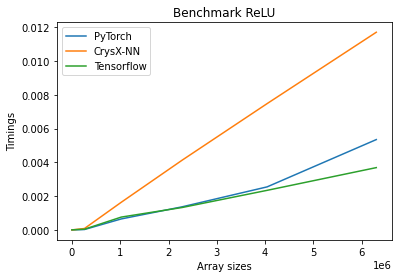

In [13]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark ReLU')
plt.show()

## Benchmark ReLU derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function. 

I will try to do the timings in a way that we can exclude this time from results.

However, it is still not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

So take the timing results with a grain of salt.

In [14]:
def tf_relu_grad(x):
    with tf.GradientTape() as g:
        g.watch(x)
        relu_values = tf.nn.relu(x)
    grad = g.gradient(relu_values, x)
    return grad#.numpy()

In [15]:
def torch_relu_grad(relu_values, x):
    device='cpu'
    gradient = torch.autograd.grad(outputs=relu_values, inputs=x,
                          grad_outputs=torch.ones(relu_values.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    return gradient

### Confirm that all frameworks give the same results

In [16]:
# Torch input
X_torch = torch.randn((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)
gradientsTorch = torch_relu_grad(relu_torch_value, X_torch)
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = ReLU_grad(X_crysx_nn)
# print(gradientsCrysx)

# Tensorflow
gradientsTF = tf_relu_grad(X_tf) # requires a computation of sigmoid values again
with tf.GradientTape() as g:
    g.watch(X_tf)
    relu_tf_value = tf.nn.relu(X_tf)
gradientsTF = g.gradient(relu_tf_value, X_tf)
del g
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - gradientsCrysx).max())


Max abs diff b/w torch and tf 0.0
Max abs diff b/w torch and CrysX 0.0


### Compare performance

Since, CrysX-NN also requires the calculation of softmax function, therefore we should also include this calculation time for PyTorch and Tensorflow.

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of softmax gradients that I have used, are a good representative of the real-world performance or not. 

Especially, the torch jacobian would be extreeeemely slowww due to the for loops. But tensorflow implementation isn't that fast either.

So we would skip the plots of timings vs array_size for benchmarks.

In [17]:
# Torch
print('PyTorch gradient only')
relu_torch_func = torch.nn.ReLU() # Get an instance of ReLU class for Pytorch
relu_torch_value = relu_torch_func(X_torch)
%timeit -n 100 torch_relu_grad(relu_torch_value, X_torch)

# CrysX
print('CrysX-NN (crysx_nn) gradient only')
%timeit -n 100 ReLU_grad(X_crysx_nn)

# Tensorflow
print('Tensorflow gradient+value')
with tf.GradientTape(persistent=False) as g:
    g.watch(X_tf)
    relu_tf_value = tf.nn.relu(X_tf)
# %timeit -n 100 g.gradient(relu_tf_value, X_tf) # Doesn't work due to multiple runs of timeit and tape not supporting it
%timeit -n 100  tf_relu_grad(X_tf)

print('Tensorflow value only')
%timeit -n 100 tf.keras.activations.relu(X_tf)


PyTorch gradient only
2.17 ms ± 57.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn) gradient only
1.03 ms ± 59.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow gradient+value
2.27 ms ± 71.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow value only
711 µs ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the above, we see that PyTorch is again quite fast a million element array. 
CrysX-NN gives decent performance.

Tensorflow is a bit tricky. Due to `%timeit` requiring multiple runs, and tape being only restricted to a single run, I had to use the other implementation of gradient using tensorflow, where the `values+gradients` are computed.

Therefore, to get a good idea of the tensorflow gradient performance I have also calculated the time taken by tensorflow for just evaluating the functions.

## Benchmark Sigmoid

### Confirm that all frameworks give the same results

In [18]:
# Torch input
X_torch = torch.randn((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)

# Torch
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)

# CrysX
sigmoid_crysx_nn_value = Sigmoid(X_crysx_nn)

# Tensorflow
sigmoid_tf_value = tf.keras.activations.sigmoid(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(sigmoid_torch_value.cpu().detach().numpy() - sigmoid_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(sigmoid_torch_value.cpu().detach().numpy() - sigmoid_crysx_nn_value).max())


Max abs diff b/w torch and tf 1.7881393e-07
Max abs diff b/w torch and CrysX 1.1920929e-07


### Compare performance

In [19]:
# Torch
print('PyTorch')
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
%timeit -n 100 sigmoid_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 100 Sigmoid(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 100 tf.keras.activations.sigmoid(X_tf)


PyTorch
1.63 ms ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn)
1.4 ms ± 183 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow
816 µs ± 55.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Compare performance with arrays of different sizes

In [20]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,3000,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.randn((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
    time = %timeit -n 100 -o sigmoid_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 100 -o Sigmoid(X_crysx_nn)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    time = %timeit -n 100 -o tf.keras.activations.sigmoid(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    

6.05 µs ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.19 µs ± 260 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.87 µs ± 544 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
371 µs ± 17.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
273 µs ± 3.74 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
73.5 µs ± 3.76 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.72 ms ± 53.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.93 ms ± 192 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
896 µs ± 155 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.94 ms ± 193 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.05 ms ± 554 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.8 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.4 ms ± 429 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
8.18 ms ± 816 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.46 m

### Plot the results

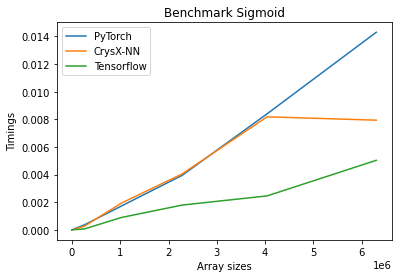

In [21]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark Sigmoid')
plt.show()


## Benchmark Sigmoid derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function. 

I will try to do the timings in a way that we can exclude this time from results.

However, it is still not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

So take the timing results with a grain of salt.

In [21]:
def tf_sigmoid_grad(x):
    with tf.GradientTape() as g:
        g.watch(x)
        sigmoid_values = tf.nn.sigmoid(x)
    grad = g.gradient(sigmoid_values, x)
    return grad#.numpy()

In [22]:
def torch_sigmoid_grad(sigmoid_values, x):
    device='cpu'
    gradient = torch.autograd.grad(outputs=sigmoid_values, inputs=x,
                          grad_outputs=torch.ones(sigmoid_values.size()).to(device),
                          create_graph=True, retain_graph=True, only_inputs=True)[0]
    return gradient

### Confirm that all frameworks give the same results

In [23]:
# Torch input
X_torch = torch.randn((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)
gradientsTorch = torch_sigmoid_grad(sigmoid_torch_value, X_torch)
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = Sigmoid_grad(X_crysx_nn)
# print(gradientsCrysx)

# Tensorflow
gradientsTF = tf_sigmoid_grad(X_tf) # requires a computation of sigmoid values again
with tf.GradientTape() as g:
    g.watch(X_tf)
    sigmoid_tf_value = tf.nn.sigmoid(X_tf)
gradientsTF = g.gradient(sigmoid_tf_value, X_tf)
del g
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - gradientsCrysx).max())


Max abs diff b/w torch and tf 1.6391277e-07
Max abs diff b/w torch and CrysX 8.009374e-08


### Compare performance

Since, CrysX-NN also requires the calculation of softmax function, therefore we should also include this calculation time for PyTorch and Tensorflow.

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of softmax gradients that I have used, are a good representative of the real-world performance or not. 

Especially, the torch jacobian would be extreeeemely slowww due to the for loops. But tensorflow implementation isn't that fast either.

So we would skip the plots of timings vs array_size for benchmarks.

In [24]:
# Torch
print('PyTorch gradient only')
sigmoid_torch_func = torch.nn.Sigmoid() # Get an instance of Sigmoid class for Pytorch
sigmoid_torch_value = sigmoid_torch_func(X_torch)
%timeit -n 100 torch_sigmoid_grad(sigmoid_torch_value, X_torch)

# CrysX
print('CrysX-NN (crysx_nn) gradient only')
%timeit -n 100 Sigmoid_grad(X_crysx_nn)

# Tensorflow
print('Tensorflow gradient+value')
with tf.GradientTape(persistent=False) as g:
    g.watch(X_tf)
    sigmoid_tf_value = tf.nn.sigmoid(X_tf)
# %timeit -n 100 g.gradient(sigmoid_tf_value, X_tf) # Doesn't work due to multiple runs of timeit and tape not supporting it
%timeit -n 100  tf_sigmoid_grad(X_tf)
print('Tensorflow value only')
%timeit -n 100 tf.keras.activations.sigmoid(X_tf)



PyTorch gradient only
1.18 ms ± 136 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn) gradient only
1.27 ms ± 68.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow gradient+value
2.42 ms ± 40.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow value only
769 µs ± 9.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In the above, we see that PyTorch is again quite fast for a million element array. 
CrysX-NN gives decent performance.

Tensorflow is a bit tricky. Due to `%timeit` requiring multiple runs, and tape being only restricted to a single run, I had to use the other implementation of gradient using tensorflow, where the `values+gradients` are computed.

Therefore, to get a good idea of the tensorflow gradient performance I have also calculated the time taken by tensorflow for just evaluating the functions.

## Benchmark Softmax

### Confirm that all frameworks give the same results

In [25]:
# Torch input
X_torch = torch.randn((1000,1000),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
softmax_torch_value = softmax_torch_func(X_torch)

# CrysX
softmax_crysx_nn_value = Softmax(X_crysx_nn)

# Tensorflow
softmax_tf_value = tf.keras.activations.softmax(X_tf)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(softmax_torch_value.cpu().detach().numpy() - softmax_tf_value.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(softmax_torch_value.cpu().detach().numpy() - softmax_crysx_nn_value).max())


Max abs diff b/w torch and tf 4.4703484e-08
Max abs diff b/w torch and CrysX 5.2154064e-08


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()


### Compare performance

In [26]:
# Torch
print('PyTorch')
softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
%timeit -n 100 softmax_torch_func(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 100 Softmax(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 100 tf.keras.activations.softmax(X_tf)


PyTorch


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


1.83 ms ± 31 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
CrysX-NN (crysx_nn)
3.17 ms ± 99.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Tensorflow
1.07 ms ± 48.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Compare performance with arrays of different sizes

In [27]:
time_torch = []
time_crysx_nn = []
time_tf = []
sizes = []

for n_size in range(10,2500,500):
    sizes.append(n_size*n_size)
    # Torch input
    X_torch = torch.randn((n_size,n_size),requires_grad=True)
    # CrysX-NN input
    X_crysx_nn = X_torch.cpu().detach().numpy()
    # Tensorflow input
    X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)
    
    ##--Timings--
    # Torch
    softmax_torch_func = torch.nn.Softmax() # Get an instance of Sigmoid class for Pytorch
    time = %timeit -n 100 -o softmax_torch_func(X_torch)
    # For time of each run
    time_torch.append(np.mean(time.timings)) 
    # For total time
#     time_torch.append(np.mean(time.all_runs)) 
    # CrysX
    time = %timeit -n 100 -o Softmax(X_crysx_nn)
    # For time of each run
    time_crysx_nn.append(np.mean(time.timings))
    # Tensorflow
    time = %timeit -n 100 -o tf.keras.activations.softmax(X_tf)
    # For time of each run
    time_tf.append(np.mean(time.timings))
    

5.7 µs ± 1.39 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
The slowest run took 5.19 times longer than the fastest. This could mean that an intermediate result is being cached.
2.04 µs ± 1.44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.9 µs ± 881 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)
342 µs ± 8.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
208 µs ± 38.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
72.2 µs ± 6.61 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.7 ms ± 32.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.33 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
818 µs ± 49.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.86 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.75 ms ± 229 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.44 ms ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.6 ms ± 303 µs per loop (mea

## Run the following for Google colab 
then restart runtime and also switch to GPU

In [ ]:

# ! pip install crysx_nn
# ! pip install IPython==7.7.0

### Plot the results

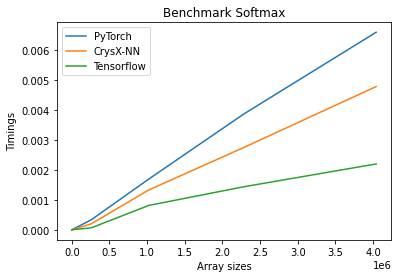

In [28]:

plt.plot(sizes,time_torch, label='PyTorch')
plt.plot(sizes,time_crysx_nn, label='CrysX-NN')
plt.plot(sizes,time_tf, label='Tensorflow')
plt.legend()
plt.xlabel('Array sizes')
plt.ylabel('Timings')
plt.title('Benchmark Softmax')
plt.show()


## Benchmark Softmax derivative (gradient) wrt input batch

This is slightly tricky. 
PyTorch and Tensorflow don't explicitly come with a function that gives the gradient. 
Rather they use atuomatic differentiation.

This is why, PyTorch would require the value of the output of the activation function as well, rather than just an input function.

Therefore, it is not really evident if the timings can be taken as a good representative of the performance of PyTorch and Tensorflow frameworks.

#### Update: Seems to be really problematic to get the jacobian of Softmax wrt inputs in an efficient manner using the PyTorch framework. 

There are ways in which you can do it, but they would be slow. (https://discuss.pytorch.org/t/how-to-compute-jacobian-matrix-in-pytorch/14968/16)

So take the timing results with a grain of salt.

In [29]:
def tf_softmax_grad(z):
#   z = tf.constant(z, dtype=tf.float32)
    with tf.GradientTape() as g:
        g.watch(z)
        a = tf.nn.softmax(z) 
    jacob = g.batch_jacobian(a, z)
    return jacob#.numpy()

In [30]:
# Reference: https://discuss.pytorch.org/t/how-to-compute-jacobian-matrix-in-pytorch/14968/16
def torch_softmax_grad(wrt):
    jacobian = []
    softmax_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
    softmax_func.eval()
    for i in range(wrt.shape[0]):
        jac = torch.autograd.functional.jacobian(softmax_func, wrt[i])
        jacobian.append(jac)
        #
    return torch.stack(jacobian, 0)

### Confirm that all frameworks give the same results

In [31]:
# Torch input
X_torch = torch.randn((100,100),requires_grad=True)
# CrysX-NN input
X_crysx_nn = X_torch.cpu().detach().numpy()
# Tensorflow input
X_tf = tf.convert_to_tensor(X_crysx_nn, dtype=tf.float32)


# Torch
# softmax_torch_func = torch.nn.Softmax() # Get an instance of Softmax class for Pytorch
softmax_torch_value = softmax_torch_func(X_torch)
device = 'cpu'
gradientsTorch = torch_softmax_grad(X_torch)#torch.autograd.grad(outputs=softmax_torch_value, inputs=X_torch,
#                           grad_outputs=torch.ones(softmax_torch_value.size()).to(device),
#                           create_graph=True, retain_graph=True, only_inputs=True)[0]
# print(gradientsTorch)

# CrysX
# softmax_crysx_nn_value = Softmax(X_crysx_nn)
gradientsCrysx = Softmax_grad(X_crysx_nn)
# print(gradientsCrysx)

# Tensorflow
# softmax_tf_value = tf.nn.softmax(X_tf)
gradientsTF = tf_softmax_grad(X_tf)
# print(gradientsTF)

#Diff b/w tf and torch
print('Max abs diff b/w torch and tf', abs(gradientsTorch.cpu().detach().numpy() - gradientsTF.numpy()).max())

#Diff b/w crysx_nn and torch
print('Max abs diff b/w torch and CrysX', abs(gradientsTorch.cpu().detach().numpy() - gradientsCrysx).max())


C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  # This is added back by InteractiveShellApp.init_path()
C:\Users\manas\anaconda3\envs\crysx_nn\lib\site-packages\torch\autograd\functional.py:482: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = func(*inputs)


Max abs diff b/w torch and tf 3.7252903e-08
Max abs diff b/w torch and CrysX 2.9802322e-08


### Compare performance

Since, CrysX-NN also requires the calculation of softmax function, therefore we should also include this calculation time for PyTorch and Tensorflow.

I would like to stress here again, that I am not really sure if the autodifferentiated implementations of softmax gradients that I have used, are a good representative of the real-world performance or not. 

Especially, the torch jacobian would be extreeeemely slowww due to the for loops. But tensorflow implementation isn't that fast either.

So we would skip the plots of timings vs array_size for benchmarks.

In [32]:
# Torch
print('PyTorch')
%timeit -n 10 torch_softmax_grad(X_torch)

# CrysX
print('CrysX-NN (crysx_nn)')
%timeit -n 10 Softmax_grad(X_crysx_nn)

# Tensorflow
print('Tensorflow')
%timeit -n 10 tf_softmax_grad(X_tf)


PyTorch
294 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
CrysX-NN (crysx_nn)
3.6 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Tensorflow
224 ms ± 2.62 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
